# **DL EXAM PROJECT**
## **GUIDO APUZZO 504834**

##**OVERVIEW**

A brief recap of the design choices I made in the exam of 20 June 2024:


*   I'm retaining all inputs, normalizing the images and performing data augmentation to increase the variability of the dataset
*   The network is composed by:

  *   a number of convolutional layers with same size padding, ReLU activation and He Initialization;
  *   a max pooling layer after each convolutional layer;

  *   a global average pooling layer;
  *   a number of dense layers with batch normalization and dropout;

  *   a softmax layer for the classification head, with 3 units;
  *   a scaled sigmoid layer for the regression head, with 4 units.


*   As loss functions, I'm using categorical cross entropy for the classification head, and mse for the regression head
*   I decided to perform tuning only on "basic" hyperparameters, keeping, for example, a dropout rate fixed at 0.2/0.3:

  1.   number of conv layers
  2.   their size
  3. number of dense layers
  4. their units
  5. batch size

*   I split the dataset to perform the training on the training set and evaluate the best parameter configuration on the validation set. Then, I use the test set to assess generalization capability.


### **FIRST OF ALL, I SET UP THE ENVIRONMENT**

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras
import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Rescaling, Lambda
from keras.models import Model, Sequential
from keras.preprocessing.image import img_to_array, array_to_img
from keras.losses import sparse_categorical_crossentropy, MeanSquaredError
from keras_tuner import HyperParameters, RandomSearch, Objective, HyperModel
from tensorflow.keras.utils import plot_model
from tensorflow import image as tf_image
from PIL import Image, ImageOps
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import cv2
import urllib.request
import zipfile
import pickle as pk

### **DATA DOWNLOAD**


In [ ]:
# ZIP data URL from GitHub
zip_url = "https://github.com/guidoapuzzo/dl-exam-zip/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
with open(data_path, 'rb') as f:
  data = pk.load(f)

### **DATA RETRIEVING**

In [ ]:
# Retrieve images and labels from loaded data
images = data['imgs']
y = data['labels']
# Since the class labels are in the same array as the bounding box coordinates we separate them.
targets = y[:,0]
bboxes = y[:,1:]

### **NORMALIZATION**

In [ ]:
images = images/255.0

### **DATA AUGMENTATION**
**Purpose:** Augments images by applying different transformations and appropriately adjusts the bounding boxes to align with the transformed images.

**Transformations:**
- Flipping Left-Right: The image is flipped horizontally, and the bounding box is adjusted accordingly.
- Flipping Up-Down: The image is flipped vertically, and the bounding box is adjusted.
- Rotations: The image is rotated by 90, 180, and 270 degrees.

**Bounding Box Adjustment:** The function transfrom_bbox is defined to calculate the new bounding box coordinates after a transformation. It uses matrix multiplication to transform the points and adjusts the coordinates to ensure they remain within the image boundaries.

**Return Values:** Returns lists of augmented images and their respective bounding boxes.


In [ ]:
def rotate_image(image, angle, image_size):
    """ Ruota l'immagine di un dato angolo e calcola la nuova bounding box """
    center_of_rotation = np.array(image_size) / 2
    rotation_matrix = cv2.getRotationMatrix2D(tuple(center_of_rotation), angle, 1.0)
    augmented_matrix = np.vstack([rotation_matrix, [0, 0, 1]])
    rotated_img = tf.image.rot90(image, k=angle//90)
    return rotated_img, augmented_matrix

def transform_bbox(bbox, transform_matrix, img_size):
    """ Applica una trasformazione alla bounding box e aggiusta le dimensioni """
    coords = np.array([
        [bbox[0], bbox[1], 1],
        [bbox[2], bbox[1], 1],
        [bbox[0], bbox[3], 1],
        [bbox[2], bbox[3], 1]
    ])
    new_coords = np.dot(transform_matrix, coords.T).T
    x_min, y_min = np.clip(np.min(new_coords, axis=0)[:2], 0, img_size)
    x_max, y_max = np.clip(np.max(new_coords, axis=0)[:2], 0, img_size)
    return np.array([x_min, y_min, x_max, y_max], dtype=int)

def apply_augmentations(original_image, original_bbox, size):
    """ Applica diverse trasformazioni all'immagine e alle bounding box. """
    augmented_images, new_bboxes = [], []

    # Flip orizzontale
    flipped_hor = np.fliplr(original_image)
    new_bbox_hor = [size[0] - original_bbox[2], original_bbox[1], size[0] - original_bbox[0], original_bbox[3]]
    augmented_images.append(flipped_hor)
    new_bboxes.append(new_bbox_hor)

    # Flip verticale
    flipped_ver = np.flipud(original_image)
    new_bbox_ver = [original_bbox[0], size[1] - original_bbox[3], original_bbox[2], size[1] - original_bbox[1]]
    augmented_images.append(flipped_ver)
    new_bboxes.append(new_bbox_ver)

    # Rotazioni
    for angle in [90, 180, 270]:
        rotated_image, rotation_matrix = rotate_image(original_image, angle, size)
        new_bbox = transform_bbox(original_bbox, rotation_matrix, size)
        augmented_images.append(rotated_image)
        new_bboxes.append(new_bbox)

    return augmented_images, new_bboxes

Now we iterate through lists images, bboxes, and targets to generate augmented images and bounding boxes. Then we aggregate all augmented images, bounding boxes, and labels into separate lists, convert these lists into numpy arrays and print the shapes of these arrays to verify the dimensions.

In [ ]:
# Raccolta di tutte le immagini e bounding box trasformate
all_aug_images, all_aug_bboxes, all_aug_labels = [], [], []

for image, bbox, label in zip(images, bboxes, targets):
    augmented_imgs, augmented_bboxes = apply_augmentations(image, bbox, (227, 227))
    all_aug_images.extend(augmented_imgs)
    all_aug_bboxes.extend(augmented_bboxes)
    all_aug_labels.extend([label] * len(augmented_imgs))

all_aug_images = np.array(all_aug_images)
all_aug_bboxes = np.array(all_aug_bboxes)
all_aug_labels = np.array(all_aug_labels)

print(all_aug_images.shape, all_aug_bboxes.shape, all_aug_labels.shape)

(930, 227, 227, 3) (930, 4) (930,)


### **ADJUST LABELS**
We need to turn labels in range [0, N-1] for sparse categorical crossentropy (N=num classes).

In [ ]:
all_aug_labels = all_aug_labels - 1
all_aug_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## **ARCHITECHTURE**
I use TensorFlow and Keras to build a convolutional neural network for classifying images and predicting bounding boxes.

First I define a custom activation function that scales the output of the sigmoid activation to the needed range

---

### *REQUIRED CLARIFICATION: SCALED MSE*
In the written exam, I forgot to scale also the mse loss function, since I didn't normalize box coordinates. Using a not scaled mse significantly worsens the performance of the model. Raw MSE values become very large and large loss values can lead to unstable gradients during backpropagation.
Anyway, it would have been much better to normalize coordinates.

I tested the model with and without scaled mse, the results with the scaled mse are very good, while with the normal mse they are not.
I leave here the implementation of the scaled mse, but without applying it to stick to what was written during the written examination.




In [ ]:
num_classes = len(np.unique(targets))
input_shape = (227,227,3)

In [ ]:
def scaled_sigmoid(x, scale=227):
    return K.sigmoid(x) * scale


def scaled_mse(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return K.mean(K.square((y_pred - y_true) / 227))

In [ ]:
class CNNBuilder(HyperModel):
  def build(self, hp):
    """Builds a convolutional neural network model based on hyperparameters."""
    input_layer = Input(shape=input_shape, dtype='float32')

    x = input_layer

    # Configurable number of convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        x = Conv2D(
            filters=hp.Int('filters_' + str(i), 8, 32, step=4),
            kernel_size=hp.Int('kernel_size_' + str(i), 3, 5),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal')(x)

        # Max pooling after each convolutional
        x = MaxPooling2D((2, 2), (2, 2))(x)

    # Global average pooling layer
    x = GlobalAveragePooling2D()(x)

    # Configurable number of Dense layers
    for j in range(hp.Int('num_dense_layers', 1, 3)):
          x = Dense(hp.Int('units_' + str(j), 64, 128, step=32), activation='relu')(x)
          x = BatchNormalization()(x)
          x = Dropout(rate=0.3)(x)

    # Output layers
    classification_output = Dense(num_classes, activation='softmax', name="classification_output")(x)
    regression_output = Dense(4, activation=lambda x: scaled_sigmoid(x, 227), name="regression_output")(x)

    # I define the model combining the outputs
    model = Model(inputs=input_layer,
                    outputs=[classification_output,regression_output],
                    name='Combined_output')

    # I define a dictionary of losses and one of metrics
    loss_dict = {
            "classification_output": 'sparse_categorical_crossentropy',
            #"regression_output": scaled_mse
            "regression_output": 'mse'
        }
    metric_dict =  {
            "classification_output": ['accuracy'],
            "regression_output": ['mse']
        }

    # I compile the model
    model.compile(optimizer=Adam(),
                  loss=loss_dict,
                  metrics=metric_dict)

    return model

### **SPLITTING**
*train_test_split* is called to divide the feature images, the class labels, and the bounding boxes into a training set (80% of the data) and a test set (20% of the data).

The training set obtained from the first split is further divided into a new training set and a validation set using another *train_test_split*. This time, 25% of the training data is reserved for validation

In [ ]:
X_train, X_test, y_train_class, y_test_class, y_train_box, y_test_box = train_test_split(
    all_aug_images, all_aug_labels, all_aug_bboxes, test_size=0.2, random_state=42, stratify=all_aug_labels)


In [ ]:
# Training and Validation
X_train, X_val, y_train_class, y_val_class, y_train_box, y_val_box = train_test_split(
    X_train, y_train_class, y_train_box, test_size=0.25, random_state=42, stratify=y_train_class)

### **TUNER CONFIGURATION**
The tuner will aim to:
- Maximize the validation accuracy for the classification output (val_classification_output_accuracy);
- Minimize the mean squared error (MSE) for the bounding box output on validation data (val_regression_output_mse).

After initializing the tuner, I show the range of values for each hyperparameter that the tuner will explore.

In [ ]:
tuner = RandomSearch(
    CNNBuilder(),
    objective=[Objective('val_classification_output_accuracy', direction='max'),
               Objective('val_regression_output_mse', direction='min')],
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project',
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
kernel_size_0 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}


### **HYPERPARAMETER TUNING, BEST MODEL SELECTION**
The function iteratively tests different configurations of the neural network to find the optimal set of hyperparameters based on validation performance.

After tuning, the function retrieves the best set of hyperparameters and iteratively prints out details regarding the architecture, including the optimal number of convolutional and dense layers, filter sizes, kernel sizes, and units in each layer.

The best model is then selected and its architecture is printed via the summary() method.

In [ ]:
def hyperparameter_search(X_train, y_train_class, y_train_box, X_val, y_val_class, y_val_box):
    hp = HyperParameters()

    # Search for the best hyperparameters
    tuner.search(X_train, [y_train_class, y_train_box],
                validation_data=(X_val, [y_val_class, y_val_box]),
                epochs=50)

    best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

    print("Optimal Hyperparameters Found:")
    print(f"""
    The optimal number of convolutional layers is {best_hyperparams.get('num_conv_layers')} with:
    """)
    for i in range(best_hyperparams.get('num_conv_layers')):
        print(f"  - {best_hyperparams.get(f'filters_{i}')} filters for conv layer {i}")
        print(f"  - kernel size {best_hyperparams.get(f'kernel_size_{i}')} for conv layer {i}")

    print(f"""
    The optimal number of dense layers is {best_hyperparams.get('num_dense_layers')} with:
    """)
    for j in range(best_hyperparams.get('num_dense_layers')):
        print(f"  - {best_hyperparams.get(f'units_{j}')} units for dense layer {j}")

    # Retrieving best model
    best_model = tuner.get_best_models(num_models=1)[0]
    print("Best Model Architecture:")
    print(best_model.summary())

    return best_model

In [ ]:
best_model = hyperparameter_search(X_train, y_train_class, y_train_box, X_val, y_val_class, y_val_box)

Trial 10 Complete [00h 00m 36s]
multi_objective: 374.92039865255356

Best multi_objective So Far: 329.96586561203003
Total elapsed time: 00h 08m 30s
Optimal Hyperparameters Found:

    The optimal number of convolutional layers is 3 with:
    
  - 8 filters for conv layer 0
  - kernel size 3 for conv layer 0
  - 28 filters for conv layer 1
  - kernel size 4 for conv layer 1
  - 32 filters for conv layer 2
  - kernel size 5 for conv layer 2

    The optimal number of dense layers is 1 with:
    
  - 64 units for dense layer 0
Best Model Architecture:
Model: "Combined_output"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)       

### **FINAL TRAINING AND EVALUATION**
Merge the training and validation sets to maximize data availability for the final training of the best model.

In [ ]:
X_train = np.concatenate([X_train, X_val])
y_train_class = np.concatenate([y_train_class, y_val_class])
y_train_box = np.concatenate([y_train_box, y_val_box])

Create a function to generate predictions that will populate the *predictions* dictionary and two functions to calculate accuracy and mean squared error for predictions made by the model and

In [ ]:
def generate_predictions(model, X_test, batch_size):
    """Generate predictions for classification and bounding boxes with the given batch size."""
    return model.predict(X_test, batch_size=batch_size)

def evaluate_classification_accuracy(true_labels, predictions):
    """Evaluates and returns the accuracy of classification predictions."""
    cat_predictions = np.argmax(predictions, axis=1)
    return accuracy_score(true_labels, cat_predictions)

def evaluate_mean_squared_error(true_boxes, predicted_boxes):
    """Evaluates and returns the mean squared error of bounding box predictions."""
    return mean_squared_error(true_boxes, predicted_boxes)

Calculate and report the performance of the model in terms of accuracy for image classification and mean squared error for bounding box predictions across the specified batch sizes.

In [ ]:
predictions = {}
epochs = 50
batch_values = [16, 32, 64, 96]

for batch_size in batch_values:
    # Retraining the model for each batch size
    best_model.fit(X_train, [y_train_class, y_train_box],
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=0.2)
    # Generate predictions after retraining
    predictions[batch_size] = generate_predictions(best_model, X_test, batch_size)


for batch_size in batch_values:
    class_pred = predictions[batch_size][0]
    box_pred = predictions[batch_size][1]

    # Calculate and print accuracy for image classification
    accuracy = evaluate_classification_accuracy(y_test_class, class_pred)
    print(f'Accuracy on image classification with batch size {batch_size}: {accuracy}')

    # Calculate and print mean squared error for bounding box predictions
    mse = evaluate_mean_squared_error(y_test_box, box_pred)
    print(f'Mean squared error on bounding box prediction with batch size {batch_size}: {mse}')

Epoch 1/50
38/38 [==============================] - 5s 53ms/step - loss: 347.4743 - classification_output_loss: 0.9939 - regression_output_loss: 346.4803 - classification_output_accuracy: 0.5462 - regression_output_mse: 346.4803 - val_loss: 331.9408 - val_classification_output_loss: 1.0988 - val_regression_output_loss: 330.8420 - val_classification_output_accuracy: 0.3960 - val_regression_output_mse: 330.8420
Epoch 2/50
38/38 [==============================] - 1s 22ms/step - loss: 341.1883 - classification_output_loss: 0.9877 - regression_output_loss: 340.2006 - classification_output_accuracy: 0.5496 - regression_output_mse: 340.2006 - val_loss: 538.2520 - val_classification_output_loss: 1.0129 - val_regression_output_loss: 537.2390 - val_classification_output_accuracy: 0.4832 - val_regression_output_mse: 537.2390
Epoch 3/50
38/38 [==============================] - 1s 19ms/step - loss: 352.6652 - classification_output_loss: 1.0050 - regression_output_loss: 351.6602 - classification_out

### **VISUALIZATION**
Just for completeness, let's plot the best model.

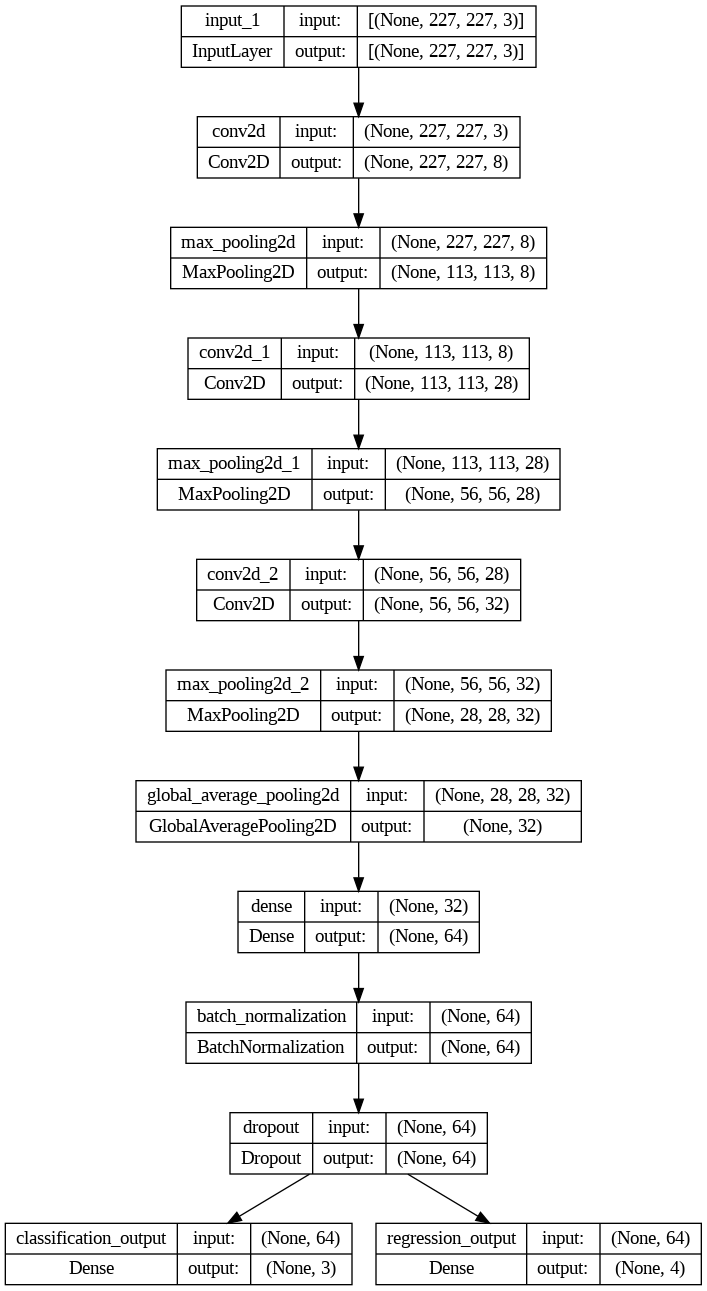

In [ ]:
plot_model(best_model, to_file='model.png', show_shapes=True, show_layer_names=True)

### **FINAL CONSIDERATIONS**

#### RESULTS WITH SCALED MSE
The following are, on average, the results I obtained by using a scaled mse:

Accuracy on image classification with batch size 16: 0.9193548387096774

Mean squared error on bounding box prediction with batch size 16: 770.1205678617848

Accuracy on image classification with batch size 32: 0.9946236559139785

Mean squared error on bounding box prediction with batch size 32: 594.9850129757731

Accuracy on image classification with batch size 64: 0.967741935483871

Mean squared error on bounding box prediction with batch size 64: 613.247374232567

Accuracy on image classification with batch size 96: 1.0

Mean squared error on bounding box prediction with batch size 96: 573.1470779705887


**They are better than using a 'normal' mse. I am very sorry about this, I should have normalised the coordinates, or at least, not forgotten to scale the mse as well.**

---

#### RESULTS WITH MSE
Accuracy on image classification with batch size 16: 0.6290322580645161

Mean squared error on bounding box prediction with batch size 16: 479.14696572353665

Accuracy on image classification with batch size 32: 0.6935483870967742

Mean squared error on bounding box prediction with batch size 32: 374.9420264240923

Accuracy on image classification with batch size 64: 0.7903225806451613
Mean squared error on bounding box prediction with batch size 64: 416.69235024412956

Accuracy on image classification with batch size 96: 0.7311827956989247

Mean squared error on bounding box prediction with batch size 96: 425.7632755569939

----

**The mse values on the bbox prediction reveal an error on the order of 15-25 pixels. Again, normalising the coordinates would probably have led to better results.**

